<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.8 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
import string

from collections import Counter, OrderedDict
from typing import List

import seaborn
seaborn.set(palette='summer')

In [12]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
import string
import random
import os

def seed_torch(seed: int=42):

  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [15]:
# Загрузим датасет
dataset = load_dataset('imdb')

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [17]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [18]:
dataset['train']['text'][0:3]

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [19]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences

for sentence in tqdm(dataset['train']['text']+dataset['test']['text']+dataset['unsupervised']['text']):
    for sent in sent_tokenize(sentence):
        if len(word_tokenize(sent)) <= word_threshold:
            sentences.append(sent.lower())

  0%|          | 0/100000 [00:00<?, ?it/s]

In [20]:
print("Всего предложений до удаления дублей:", len(sentences))
print("Всего предложений после удаления дублей:", len(set(sentences)))

Всего предложений до удаления дублей: 802455
Всего предложений после удаления дублей: 760556


In [21]:
sentences = list(set(sentences))
sentences[0:3]

['i am amazed anyone likes this film.',
 'now i have absolutely nothing against homosexuality in films.',
 '), years later billy returns home to his family.']

In [22]:
sentences_final = []

# Получить отдельные предложения и поместить их в sentences

for sentence in tqdm(sentences):
    for sent in sent_tokenize(sentence):
        sentences_final.append(word_tokenize(sent))

  0%|          | 0/760556 [00:00<?, ?it/s]

In [23]:
print(sentences_final[0])
print(sentences_final[1])
print(sentences_final[2])

['i', 'am', 'amazed', 'anyone', 'likes', 'this', 'film', '.']
['now', 'i', 'have', 'absolutely', 'nothing', 'against', 'homosexuality', 'in', 'films', '.']
[')', ',', 'years', 'later', 'billy', 'returns', 'home', 'to', 'his', 'family', '.']


Посчитаем для каждого слова его встречаемость.

In [24]:
words = Counter()

# Расчет встречаемости слов

for sentence in tqdm(sentences_final):
    for word in sentence:
        words[word]+=1

  0%|          | 0/770216 [00:00<?, ?it/s]

In [25]:
len(words)

147834

In [26]:
words.most_common()[:5]

[('.', 660692), ('the', 617093), (',', 466947), ('a', 305582), ('and', 298168)]

In [27]:
sorted(words, key=words.get, reverse=True)[:5]

['.', 'the', ',', 'a', 'and']

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [28]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря

for word in sorted(words, key=words.get, reverse=True)[:vocab_size]:
        vocab.add(word)

In [29]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [30]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


In [31]:
vocab = list(vocab)
vocab[:6]

['moriarty', "'where", 'netflix', 'neighbours', 'fugitive', 'tour']

### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [32]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [33]:
print(word2ind)

{'moriarty': 0, "'where": 1, 'netflix': 2, 'neighbours': 3, 'fugitive': 4, 'tour': 5, 'contraptions': 6, 'co-host': 7, 'curvaceous': 8, 'pepper': 9, 'maeve': 10, 'deedee': 11, 'gabe': 12, 'web': 13, 'fess': 14, 'teach': 15, 'wrinkled': 16, 'merger': 17, 'partook': 18, 'paralysis': 19, 'staunton': 20, 'mercies': 21, 'd.w.': 22, 'consecutive': 23, 'greenpeace': 24, 'lauter': 25, 'grimly': 26, 'reincarnated': 27, 'intern': 28, 'foolishly': 29, 'black/white': 30, 'calmed': 31, 'hedeen': 32, 'exodus': 33, 'loyalists': 34, 'scatter': 35, 'hammering': 36, 'represented': 37, 'rueda': 38, 'league': 39, 'sorcerer': 40, 'mcbride': 41, 'immortal': 42, 'washed': 43, 'omissions': 44, 'sessions': 45, 'team': 46, 'conspicuous': 47, 'stink-bomb': 48, 'cadet': 49, 'hiller': 50, 'bachchan': 51, 'aspiring': 52, 'procedures': 53, "'cinema": 54, 'mannerism': 55, 'wrestling': 56, 'governments': 57, 'mailing': 58, 'bypass': 59, 'compounded': 60, 'tv-': 61, 'ape': 62, 'pervasive': 63, 'reduce': 64, 'conrad': 6

In [34]:
print(ind2word)

{0: 'moriarty', 1: "'where", 2: 'netflix', 3: 'neighbours', 4: 'fugitive', 5: 'tour', 6: 'contraptions', 7: 'co-host', 8: 'curvaceous', 9: 'pepper', 10: 'maeve', 11: 'deedee', 12: 'gabe', 13: 'web', 14: 'fess', 15: 'teach', 16: 'wrinkled', 17: 'merger', 18: 'partook', 19: 'paralysis', 20: 'staunton', 21: 'mercies', 22: 'd.w.', 23: 'consecutive', 24: 'greenpeace', 25: 'lauter', 26: 'grimly', 27: 'reincarnated', 28: 'intern', 29: 'foolishly', 30: 'black/white', 31: 'calmed', 32: 'hedeen', 33: 'exodus', 34: 'loyalists', 35: 'scatter', 36: 'hammering', 37: 'represented', 38: 'rueda', 39: 'league', 40: 'sorcerer', 41: 'mcbride', 42: 'immortal', 43: 'washed', 44: 'omissions', 45: 'sessions', 46: 'team', 47: 'conspicuous', 48: 'stink-bomb', 49: 'cadet', 50: 'hiller', 51: 'bachchan', 52: 'aspiring', 53: 'procedures', 54: "'cinema", 55: 'mannerism', 56: 'wrestling', 57: 'governments', 58: 'mailing', 59: 'bypass', 60: 'compounded', 61: 'tv-', 62: 'ape', 63: 'pervasive', 64: 'reduce', 65: 'conrad

In [35]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [36]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [37]:
train_sentences, eval_sentences = train_test_split(sentences_final, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [38]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [39]:
def train_model(model, train_dataloader, eval_dataloader, num_epoch:int = 5):
    losses = []
    perplexities_tr = []
    perplexities_eval = []

    seed_torch()
    model = model
    seed_torch()
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    seed_torch()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities_tr.append(evaluate(model, criterion, train_dataloader))
        perplexities_eval.append(evaluate(model, criterion, eval_dataloader))

    return model, losses, perplexities_tr, perplexities_eval

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [40]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [41]:
def plotting(losses: List, perplexities_tr: List, perplexities_eval: List):

    plt.plot(np.arange(len(losses)), losses)
    plt.title('Losses')
    plt.xlabel("epoch")
    plt.show()
    print(f'Min losses on train: {min(losses)}')

    plt.plot(np.arange(len(perplexities_tr)), perplexities_tr)
    plt.title('Perplexity')
    plt.xlabel("epoch")
    plt.show()
    print(f'Min perplexities on train: {min(perplexities_tr)}')

    plt.plot(np.arange(len(perplexities_eval)), perplexities_eval)
    plt.title('Perplexity on eval')
    plt.xlabel("epoch")
    plt.show()
    print(f'Min perplexities on eval: {min(perplexities_eval)}')

In [42]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 32) -> str:
    device = 'cuda'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in nltk.word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words


In [43]:
# Обучите модель здесь
num_epoch = 5

model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
model_gru, losses_gru, perplexities_tr_gru, perplexities_eval_gru = train_model(model, train_dataloader, eval_dataloader, num_epoch)

Training epoch 1::   0%|          | 0/4814 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4814 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4814 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4814 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4814 [00:00<?, ?it/s]

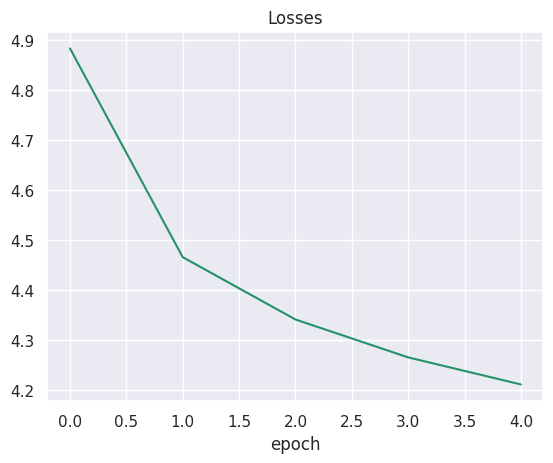

Min losses on train: 4.211983689837898


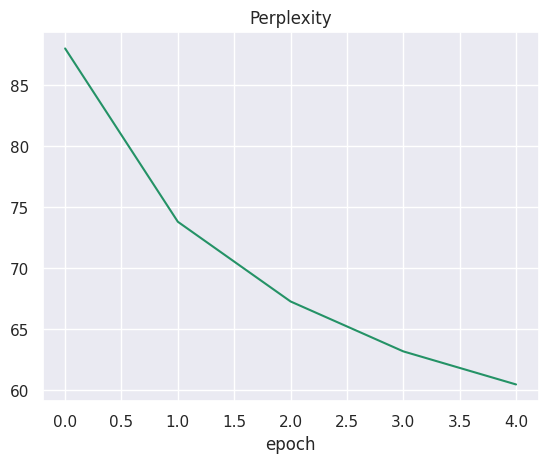

Min perplexities on train: 60.482727131607824


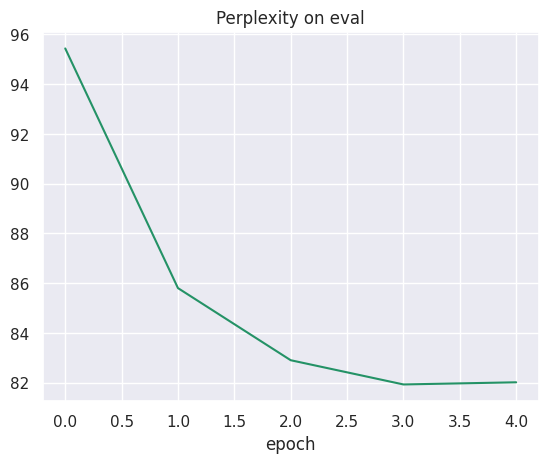

Min perplexities on eval: 81.93082297442363


In [44]:
plotting(losses_gru, perplexities_tr_gru, perplexities_eval_gru)

In [45]:
%%time

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
model_0 = model_gru.to(device)
perplexity_te_gru = evaluate(model_gru, criterion, test_dataloader)
perplexity_te_gru

CPU times: user 23 s, sys: 36 ms, total: 23 s
Wall time: 22.9 s


82.23140439638664

In [46]:
print('too bad only a few people saw this film, this film really deserves better')
generate_sequence(model_gru, starting_seq='too bad only a few people saw this film, this film ')

too bad only a few people saw this film, this film really deserves better


'<bos> too bad only a few people saw this film , this film was a little too long . <eos>'

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [47]:
# Проведите второй эксперимент

class LanguageModel_LSTM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=3)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [48]:
# Обучите модель здесь
num_epoch = 5

model = LanguageModel_LSTM(hidden_dim=512, vocab_size=len(vocab)).to(device)
model_lstm, losses_lstm, perplexities_tr_lstm, perplexities_eval_lstm = train_model(model, train_dataloader, eval_dataloader, num_epoch)

Training epoch 1::   0%|          | 0/4814 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plotting(losses_lstm, perplexities_tr_lstm, perplexities_eval_lstm)

In [ ]:
%%time

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
model_1 = model_lstm.to(device)
perplexity_te_lstm = evaluate(model, criterion, test_dataloader)
perplexity_te_lstm

In [ ]:
print('too bad only a few people saw this film, this film really deserves better')
generate_sequence(model_lstm, starting_seq='too bad only a few people saw this film, this film ')

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [ ]:
def perplexities_model(per_1: List, per_2: List, datasets: str):
    plt.figure(figsize=(8,6))
    plt.plot(per_1, 'r', label='Model_GRU')
    plt.plot(per_2, 'g', label='Model_LSTM')
    plt.title(f'Perplexities comparing of {datasets}')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.show()
    print('Min of preplexity Model_GRU',min(per_1))
    print('Min of preplexity Model_LSTM',min(per_2))

In [ ]:
import pandas as pd
def perplexities_model_table(per_tr_1: List, per_tr_2: List, per_eval_1: List, per_eval_2: List, n_epoch:int=5):
    df = pd.DataFrame({'Model_GRU_tr':per_tr_1,'Model_GRU_eval':per_eval_1,'Model_LSTM_tr': per_tr_2, 'Model_LSTM_eval': per_eval_2})
    display(df.describe())
    df = df.T
    df.columns = [f'epoch_{i+1}' for i in range(n_epoch)]
    return df

In [ ]:
perplexities_model(perplexities_tr_gru,perplexities_tr_lstm, 'TRAIN')

In [ ]:
perplexities_model(perplexities_eval_gru,perplexities_eval_lstm, 'EVAL')

In [ ]:
print('TEST preplexity Model_GRU',perplexity_te_gru)
print('TEST preplexity Model_LSTM',perplexity_te_lstm)

In [ ]:
perplexities_model_table(perplexities_tr_gru,perplexities_tr_lstm,perplexities_eval_gru,perplexities_eval_lstm)

---
# Основные изменения и условия перед обучением:
1) Все три датасета текстов были объеденены в один;

2) Слова в предложениях были приведены к нижнему регистру;

3) Были удалены дубликаты предложений;

4) Токенизатор предложений и слов использован библиотекой nltk;

5) Исправлена ошибка при разделении предложений на train, eval, test.

---
## Эксперимент 1 (описание):
* Модель GRU;
* Размер скрытого слоя = 256;
* Вероятность dropout = 0.1;
* Количество эпох = 5.

#### Результаты:
**Перплексия** на трейне и евал датасетах снижается постепенно при увеличении количества эпох. Минимальное значение на **трейне** = 60.7, на **евал** = 75.5. Перплексия на **тестовом** дататесе = 75.7.

* **Плюсы**: Достаточно быстрое обучение, стабильность, не переобучается.

* **Минусы**: Скудная генерация текстов. Хотелось бы лучше

---
## Эксперимент 2 (описание):
* Модель LSTM;
* Размер скрытого слоя = 512;
* Количество слоев в LSTM = 3;
* Вероятность dropout = 0.2;
* Количество эпох = 5.

#### Результаты:
**Перплексия**  на трейне и евал датасетах снижается резко на маленьком количестве эпох, и далее стабилизируется. Минимальное значение на **трейне** = 61.6, на **евал** = 81.6. Перплексия на **тестовом** дататесе = 82.1.

* **Плюсы**: Стабильность при большом количестве эпох, лучшие связи и генерация текстов, не переобучается.

* **Минусы**: При маленьком количестве эпох хуже, чем GRU. Очень трудозатратно.

---

**ИТОГИ**. Лучшая модель оказалась из второго эксперимента!

